# Notebook for comparing intensities extracted from Janus structures
Ondrej Dyck

Jun 30, 2022

Sample supplied by

Sumner Harris

Kai Xiao



In [1]:
# import libraries
import numpy as np
import atomai as aoi
import matplotlib.pyplot as plt
import torch
print(torch.cuda.is_available())
import pandas as pd
from matplotlib.patches import Rectangle
from PIL import Image
import seaborn as sns
import os
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec

# local libraries
sys.path.append(".")
from saved_models import dcnn
from saved_models.atomfind import *

True


In [34]:

path1 = 'Partially converted images'
path2 = 'Fully converted images'
fnames1 = [name for name in os.listdir(path1) if '_rescaled' not in name]
fnames2 = [name for name in os.listdir(path2) if '_rescaled' not in name]

# we want a list of all the names but we still want to know which folder they came from so we leave fnames1 and fnames2 and create a new list
names = fnames1.copy()
names.extend(fnames2)
print(names)


['SuperScan (HAADF) 31_corrected.tif', 'SuperScan (HAADF) 19_corrected.tif', 'SuperScan (HAADF) 17_corrected.tif', 'SuperScan (HAADF) 8_corrected.tif', 'SuperScan (HAADF) 16_corrected.tif', 'SuperScan (HAADF) 27_corrected.tif', 'SuperScan (HAADF) 10_corrected.tif', 'SuperScan (HAADF) 25_corrected.tif', 'SuperScan (HAADF) 14_corrected.tif', 'SuperScan (HAADF) 18_corrected.tif', 'SuperScan (HAADF) 26_corrected.tif', 'SuperScan (HAADF) 3_corrected.tif', 'SuperScan (HAADF) 4_corrected.tif', 'SuperScan (HAADF) 12_corrected.tif', 'SuperScan (HAADF) 15_corrected.tif', 'SuperScan (HAADF) 9_corrected.tif', 'SuperScan (HAADF) 13_corrected.tif', 'SuperScan (HAADF) 16_corrected.tif', 'SuperScan (HAADF) 14_corrected.tif', 'SuperScan (HAADF) 12_corrected.tif', 'SuperScan (HAADF) 15_corrected.tif']


Make a list of all the paths to the images so we can iterate through them easily later.

In [35]:
all_names = []
for name in fnames1:
    all_names.append(path1+'/'+name)
for name in fnames2:
    all_names.append(path2+'/'+name)

all_names

['Partially converted images/SuperScan (HAADF) 31_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 19_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 17_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 8_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 16_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 27_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 10_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 25_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 14_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 18_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 26_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 3_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 4_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 12_corrected.tif',
 'Partially converted images/SuperScan (HAADF) 15_corrected.tif',
 'Partially c

Helper functions for later.

In [9]:
def get_summed_intensity_over_disk(atom_pos_0, atom_pos_1, radius_in_pixels, image):
	'''
	Inputs:
		atom_pos_0 = y pixel value of an atom location (assumes float)
		atom_pos_1 = x pixel value of an atom location (assumes float)
		radius_in_pixels = radius in pixels (assumes integer) of the area within which the sum should be performed
		image = the image with the data to be summed

	Returns:
		Tuple containing (sum of pixels within the radius, number of pixels summed)
	'''
	# first slice a square from the image centered on the atom positions
	# we need to specify where the slice will start and end
	int_pos_0 = int(atom_pos_0)
	int_pos_1 = int(atom_pos_1)
	start_0 = int_pos_0-radius_in_pixels
	end_0 = int_pos_0+radius_in_pixels+1
	start_1 = int_pos_1-radius_in_pixels
	end_1 = int_pos_1+radius_in_pixels+1

	# perform the slice -- this will fail if the slice index is out of bounds
	square = image[start_0 : end_0 , start_1 : end_1]

	# calculate which pixels are "within" the radius and add them to a list
	center_0 = radius_in_pixels + (atom_pos_0-int_pos_0)
	center_1 = radius_in_pixels + (atom_pos_1-int_pos_1)
	pixel_list = []
	for dim_0 in range(np.shape(square)[0]):
		for dim_1 in range(np.shape(square)[1]):
			distance = np.sqrt((center_0-dim_0)**2 + (center_1-dim_1)**2)
			
			if distance <= radius:
				pixel_list.append(square[dim_0][dim_1])

	# return the sum and number of pixels summed over
	return (sum(pixel_list), len(pixel_list))



# plot histogram

def create_histogram(data, num_bins):
	'''
	Input:
		data = 1D vector of data
		num_bins = number of bins to use

	Output:
		hist_vector = vector of counts in each bin
		bin_width = width of the bins
		offset = starting point of the histogram i.e. minimum data value
	'''

	data_min = min(data)
	data_max = max(data)
	bin_size = (data_max-data_min)/(num_bins-4)
	hist_vector = np.zeros(num_bins)
	bins = np.linspace(data_min-(2*bin_size), data_max+(2*bin_size), num_bins+1)

	for data_point in range(len(data)):

		for step in range(len(bins)-1):
			if data[data_point] <= bins[step] and data[data_point] > bins[step-1]:
				hist_vector[step] += 1




	offset = data_min-(2*bin_size)
	bin_width = bins[1]-bins[0]
	return hist_vector, bin_width, offset, bins

### Load DCNN

In [10]:
# load up saved model
code_foldername = "saved_models/"
code_filename = 'G-Si-DFT0-1-4-best_weights.pt'
print(torch.cuda.is_available())

model = dcnn.atomsegnet()
model = dcnn.load_torchmodel(code_foldername+code_filename, model)

True


### Find Atoms

In [11]:

scale = 0.0078 # nm/pix
atomsdf = pd.DataFrame(columns=['atom number', 'x', 'y', 'intensity', 'scale', 'image name', 'conversion'])
threshold=0.08 # change this parameter to adjust how the DCNN output gets converted to atomic positions
histogram_equalization = False

    

for name in all_names:
    print(name)
    with Image.open(name) as img:
        im = np.array(img)
    
    # rescale
    image = (im - np.min(im))/np.max(im)

    # Make a prediction using a loaded DL model
    img, dec = dl_image(image, model, histogram_equalization=histogram_equalization).decode()

    # Exract atomic coordinates from the neural network output
    coord = find_atoms(dec, threshold=threshold).get_all_coordinates()

    # calculate intensities
    radius = 4
    atom_intensities = []
    atom_number = []
    scale_vec = []
    x_vec = []
    y_vec = []
    image_name = []
    for atom_num in range(np.shape(coord[0])[0]):
        atom_pos_0 = coord[0][atom_num][0]
        atom_pos_1 = coord[0][atom_num][1]

        # check if the radius will go off the edge of the image
        # if this is true then we just ignore that atom
        if atom_pos_0 < radius or atom_pos_1 < radius or atom_pos_0 + radius > np.shape(img[0,:,:,0])[0] or atom_pos_1 + radius > np.shape(img[0,:,:,0])[1]:

            pass
        
        else:
            intensity_sum, num_pixels = get_summed_intensity_over_disk(atom_pos_0, atom_pos_1, radius, img[0,:,:,0])
            atom_intensities.append(intensity_sum/num_pixels)
            atom_number.append(atom_num)
            scale_vec.append(scale)
            x_vec.append(atom_pos_1)
            y_vec.append(atom_pos_0)
            image_name.append(name)

    # determine which experiment this was
    if path1 in name:
        conversion = ['partial']
    else:
        conversion = ['full']

    # put data in dataframe
    data_inst = pd.DataFrame({'atom number': np.array(atom_number, dtype=np.int32),
                    'x': np.array(x_vec, dtype=np.float32),
                    'y': np.array(y_vec, dtype=np.float32),
                    'intensity': np.array(atom_intensities, dtype=np.float32),
                    'scale': np.array(scale_vec, dtype=np.float32),
                    'image name': str(name),
                    'conversion': conversion*len(atom_number)
                     })

    atomsdf = pd.concat((atomsdf, data_inst), axis = 0, ignore_index=True)




Partially converted images/SuperScan (HAADF) 31_corrected.tif
1 image was decoded in approximately 1.38 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 19_corrected.tif
1 image was decoded in approximately 1.19 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 17_corrected.tif
1 image was decoded in approximately 0.27 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 8_corrected.tif
1 image was decoded in approximately 1.23 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 16_corrected.tif
1 image was decoded in approximately 0.27 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 27_corrected.tif
1 image was decoded in approximately 1.11 seconds
Atomic/defect coordinates extracted
Partially converted images/SuperScan (HAADF) 10_corrected.tif
1 image was decoded in approximately 1.08 seconds
A

### Plot Example

To visualize the output of the DCNN let's plot the last result.

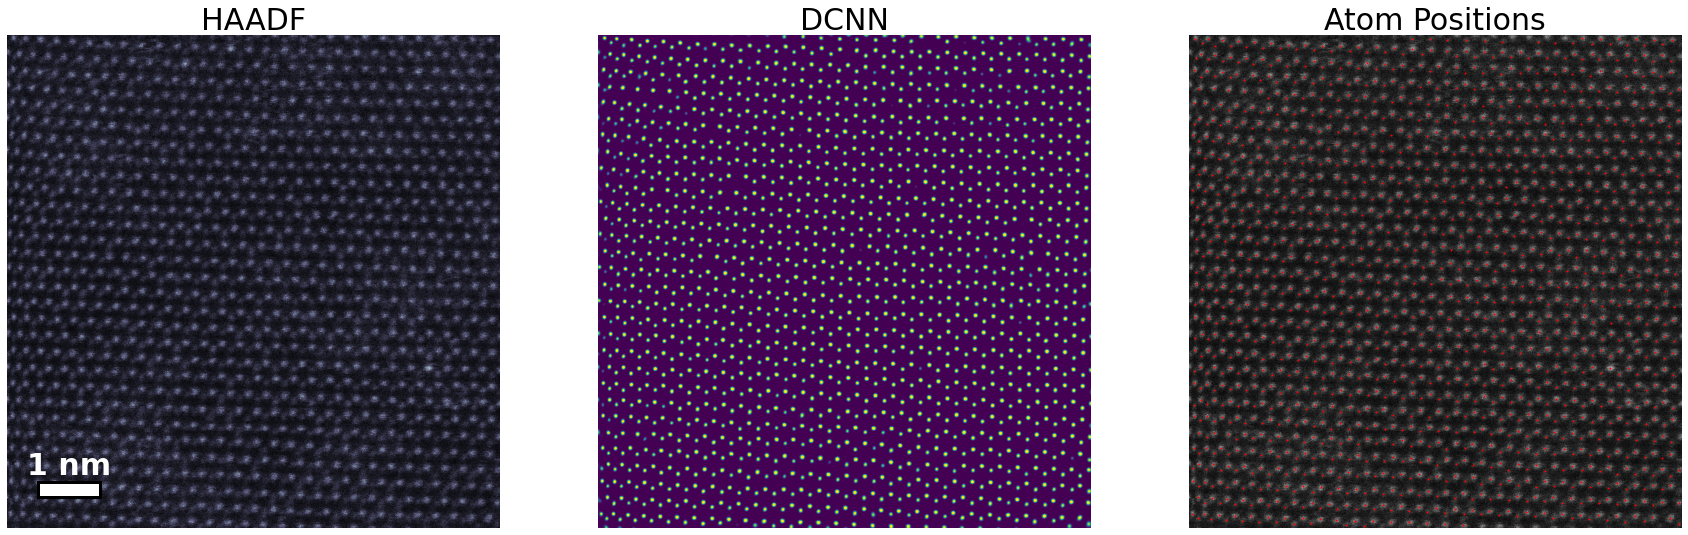

In [13]:
#atom_pos_0 = coord[0].T[0]
#atom_pos_1 = coord[0].T[1]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,20), facecolor='white')

ax[0].imshow(image, cmap='bone')
ax[0].set_axis_off()
ax[0].set_title('HAADF', fontsize=30)
# need scale bar
x = np.shape(image)[0]/16
rough_width = np.shape(image)[0]/4
nms = int(rough_width*scale)
width = int(nms/scale)
height = np.shape(image)[1]/32
y = np.shape(image)[1]-x-height
rect = Rectangle((x,y), width=width, height=height,
                    edgecolor = 'black',
                    facecolor = 'white',
                    fill=True,
                    lw=3)

ax[0].add_patch(rect)
ax[0].annotate(str(nms)+' nm', xy=(x+width/2,y-height/2), color='w', size=30, ha='center', weight='bold')

ax[1].imshow(dec[0,:,:,0])
ax[1].set_axis_off()
ax[1].set_title('DCNN', fontsize=30)

ax[2].imshow(image, cmap='gray')
ax[2].scatter(data_inst['x'], data_inst['y'], s=1, color='red')
ax[2].set_axis_off()
ax[2].set_title('Atom Positions', fontsize=30)

plt.show()

We now have all the extracted data stored in a Pandas DataFrame. Let's have a look.

In [14]:
atomsdf

atom number            x            y intensity   scale  \
0               0   740.857117     5.404762  0.176087  0.0078   
1               1    704.25354     5.450704  0.186435  0.0078   
2               2    284.98822     5.905882  0.316466  0.0078   
3               3   321.764038     6.404494   0.34756  0.0078   
4               4   928.980408     5.352941  0.105391  0.0078   
...           ...          ...          ...       ...     ...   
49786        1655  1018.942139  1016.049561  0.201568  0.0078   
49787        1656   531.274719  1016.054932  0.424358  0.0078   
49788        1657   326.022461  1017.977539  0.226118  0.0078   
49789        1658   569.861694       1018.5  0.385101  0.0078   
49790        1659    364.44928  1018.811584  0.202024  0.0078   

                                              image name conversion  
0      Partially converted images/SuperScan (HAADF) 3...    partial  
1      Partially converted images/SuperScan (HAADF) 3...    partial  
2      Partially converted images/SuperScan (HAADF) 3...    partial  
3      Partially converted images/SuperScan (HAADF) 3...    partial  
4      Partially converted images/SuperScan (HAADF) 3...    partial  
...                                                  ...        ...  
49786  Fully converted images/SuperScan (HAADF) 15_co...       full  
49787  Fully converted images/SuperScan (HAADF) 15_co...       full  
49788  Fully converted images/SuperScan (HAADF) 15_co...       full  
49789  Fully converted images/SuperScan (HAADF) 15_co...       full  
49790  Fully converted images/SuperScan (HAADF) 15_co...       full  

[49791 rows x 7 columns]

### Plot Histogram of Extracted Intensities

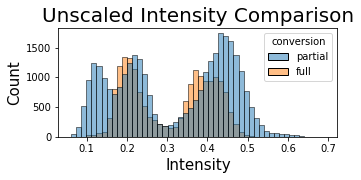

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2), facecolor='white')
sns.histplot(data=atomsdf, x='intensity', hue='conversion', bins=50, ax=ax)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Intensity', fontsize=15)
ax.set_title('Unscaled Intensity Comparison', fontsize=20)

fig.savefig('unscaled intensity comparison.png', bbox_inches='tight', dpi=300)

# svg images can be opened and edited further/composed into figures using a vector graphics program like Inkscape
fig.savefig('unscaled intensity comparison.svg', bbox_inches='tight')
plt.show()

There are three clear peaks in the partially converted sample and two clear peaks in the fully converted sample. But because we are comparing multiple images from both we need to make sure that the intensities do not vary from one image to the next. Let's look at how they compare.

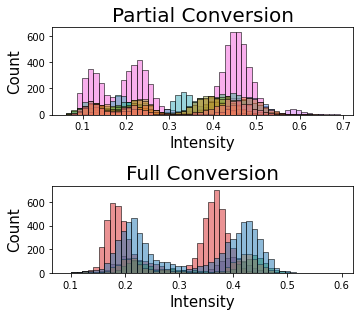

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(5,4), facecolor='white')
fig.tight_layout(h_pad=5)
sns.histplot(data=atomsdf[atomsdf['conversion']=='partial'], x='intensity', hue='image name', bins=50, ax=ax[0], legend=False)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].set_xlabel('Intensity', fontsize=15)
ax[0].set_title('Partial Conversion', fontsize=20)

sns.histplot(data=atomsdf[atomsdf['conversion']=='full'], x='intensity', hue='image name', bins=50, ax=ax[1], legend=False)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].set_xlabel('Intensity', fontsize=15)
ax[1].set_title('Full Conversion', fontsize=20)

fig.savefig('misaligned intensities.png', bbox_inches='tight', dpi=300)
fig.savefig('misaligned intensities.svg', bbox_inches='tight')
plt.show()

Image intensity is not consistent from one image to the next. This can result from changes in beam current and the fact that we removed the background intensity from our images in a preprocessing step. We want to align these peaks better so that we can compare intensity across the images. To do this we will fit gaussians to each peak and adjust all intensities so that they line up.

In [18]:
# Define the Gaussian function
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Define a double gaussian by summing two
def double_gauss(x, A1, x01, sigma1, A2, x02, sigma2):
    return gauss(x, A1, x01, sigma1) + gauss(x, A2, x02, sigma2)

# Define a triple gaussian by summing three
def triple_gauss(x, A1, x01, sigma1, A2, x02, sigma2, A3, x03, sigma3):
    return gauss(x, A1, x01, sigma1) + gauss(x, A2, x02, sigma2) + gauss(x, A3, x03, sigma3)

# Define a quad gaussian by summing four
def quad_gauss(x, A1, x01, sigma1, A2, x02, sigma2, A3, x03, sigma3, A4, x04,sigma4):
    return gauss(x, A1, x01, sigma1) + gauss(x, A2, x02, sigma2) + gauss(x, A3, x03, sigma3) + gauss(x, A4, x04, sigma4)

# Define a triple gaussian by summing three but keep sigmas the same
def triple_gauss_fixed_sigma(x, A1, x01, A2, x02, A3, x03, sigma):
    return gauss(x, A1, x01, sigma) + gauss(x, A2, x02, sigma) + gauss(x, A3, x03, sigma)

Fit each histogram.

Partially converted images/SuperScan (HAADF) 31_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 19_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 17_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 8_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 16_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 27_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 10_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 25_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 14_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 18_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 26_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 3_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 4_corrected_rescaled.tif
Partially converted images/SuperScan (HAADF) 12_corrected_rescaled.tif
Partially

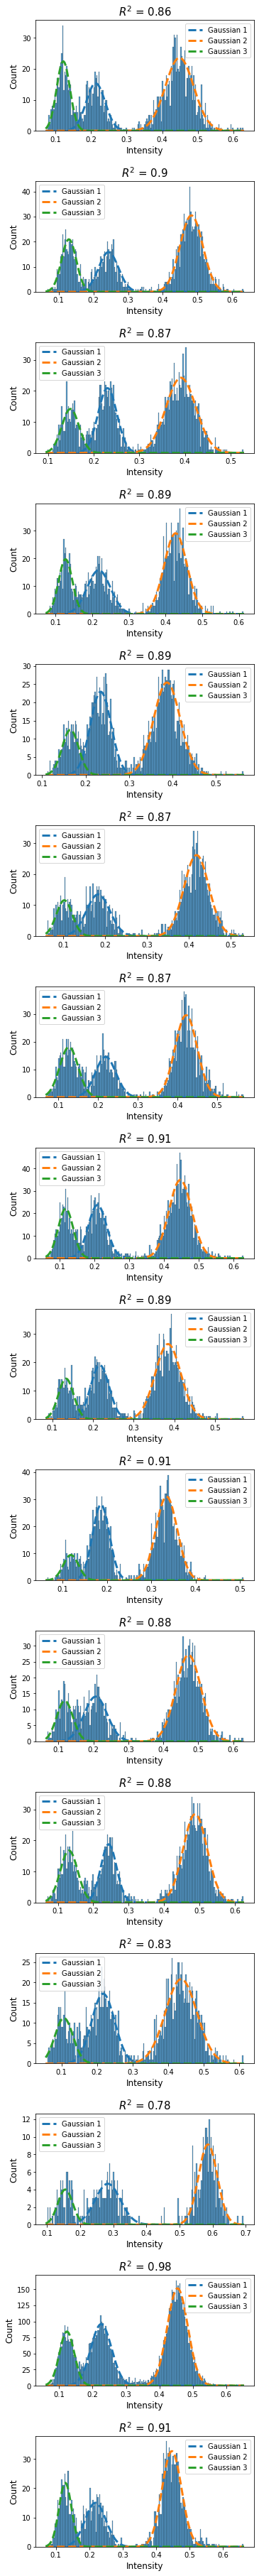

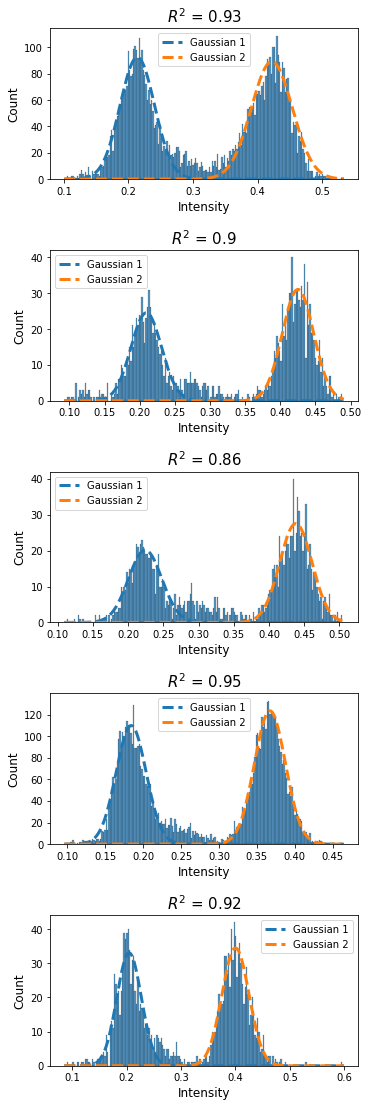

In [27]:


def get_r_squared(f, xdata, ydata, parameters):
    residuals = ydata- f(xdata, *parameters)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

num_bins = 200

linewidth = 3
fig, ax = plt.subplots(nrows=len(fnames1), ncols=1, figsize=(5,50), facecolor='white')
fig.tight_layout(h_pad=5)

fig2, ax2 = plt.subplots(nrows=len(fnames2), ncols=1, figsize=(5,15), facecolor='white')
fig2.tight_layout(h_pad=5)

counter1 = 0
counter2 = 0
scaled_intensity = np.zeros((atomsdf.shape[0]))
partial_parms=[]
full_parms=[]
partial_R = []
full_R = []
for im_name in all_names:

    # get intensities from the dataframe
    these_atoms = atomsdf[atomsdf['image name'] == im_name]
    these_atoms_ind = these_atoms.index
    intensities = np.array(these_atoms['intensity'])

    # create histogram data from the intensities
    hist_vector, bin_width, offset, bins = create_histogram(intensities, num_bins)

    # fit gaussian
    conversion_state = these_atoms.iloc[0]['conversion']
    #print(conversion_state)
    if conversion_state=='partial':
        if counter1==0:
            parameters, covariance = curve_fit(triple_gauss, bins[:-1], hist_vector)
            partial_parms.append(parameters)
            r_squared = get_r_squared(triple_gauss, bins[:-1], hist_vector, parameters)
            partial_R.append(r_squared)

        else:
            try:
                parameters, covariance = curve_fit(triple_gauss, bins[:-1], hist_vector, p0=partial_parms[0])
                partial_parms.append(parameters)
                r_squared = get_r_squared(triple_gauss, bins[:-1], hist_vector, parameters)
                partial_R.append(r_squared)
            except:
                parameters, covariance = curve_fit(triple_gauss, bins[:-1], hist_vector, p0=partial_parms[1])
                partial_parms.append(parameters)
                r_squared = get_r_squared(triple_gauss, bins[:-1], hist_vector, parameters)
                partial_R.append(r_squared)

            if r_squared<0.8:
                temp = partial_parms[1]
                temp[0] = 1.5
                temp[3] = 2.9
                temp[6] = 5.9
                parameters, covariance = curve_fit(triple_gauss, bins[:-1], hist_vector, p0=temp)
                partial_parms.append(parameters)
                r_squared = get_r_squared(triple_gauss, bins[:-1], hist_vector, parameters)
                partial_R.append(r_squared)



        # generate data based on the optimized fit
        fit_y1 = gauss(bins[:-1], *parameters[0:3])
        fit_y2 = gauss(bins[:-1], *parameters[3:6])
        fit_y3 = gauss(bins[:-1], *parameters[6:9])
        #x = np.linspace(0, np.max(intensities), num_bins)

        # plot gauss fits
        sns.histplot(intensities, bins=num_bins, ax=ax[counter1], kde=False)
        ax[counter1].set_xlabel('Intensity', fontsize=12)
        ax[counter1].set_ylabel('Count', fontsize=12)
        ax[counter1].set_title('$R^2$ = '+str(np.around(r_squared, decimals=2)), fontsize=15)
        ax[counter1].plot(bins[:-1], fit_y1, label='Gaussian 1', linewidth=linewidth, linestyle='--')
        ax[counter1].plot(bins[:-1], fit_y2, label='Gaussian 2', linewidth=linewidth, linestyle='--')
        ax[counter1].plot(bins[:-1], fit_y3, label='Gaussian 3', linewidth=linewidth, linestyle='--')
        ax[counter1].legend()
        counter1+=1

    else:
        #print('Fitting fully converted')

        if counter2==0:
            parameters, covariance = curve_fit(double_gauss, bins[:-1], hist_vector, p0=[50, 0.2,0.1,50,0.45,0.1])
            full_parms.append(parameters)
            r_squared = get_r_squared(double_gauss, bins[:-1], hist_vector, parameters)
            full_R.append(r_squared)
        else:
            parameters, covariance = curve_fit(double_gauss, bins[:-1], hist_vector, p0=full_parms[0])
            full_parms.append(parameters)
            r_squared = get_r_squared(double_gauss, bins[:-1], hist_vector, parameters)
            full_R.append(r_squared)

        # generate data based on the optimized fit
        fit_y1 = gauss(bins[:-1], *parameters[0:3])
        fit_y2 = gauss(bins[:-1], *parameters[3:6])
        #x = np.linspace(0, np.max(intensities), num_bins)

        sns.histplot(intensities, bins=num_bins, ax=ax2[counter2], kde=False)
        ax2[counter2].set_xlabel('Intensity', fontsize=12)
        ax2[counter2].set_ylabel('Count', fontsize=12)
        ax2[counter2].set_title('$R^2$ = '+str(np.around(r_squared, decimals=2)), fontsize=15)
        ax2[counter2].plot(bins[:-1], fit_y1, label='Gaussian 1', linewidth=linewidth, linestyle='--')
        ax2[counter2].plot(bins[:-1], fit_y2, label='Gaussian 2', linewidth=linewidth, linestyle='--')
        ax2[counter2].legend()
        counter2+=1
    #print(parameters)
    scaled_intensity[these_atoms_ind] = ((intensities - parameters[1])/parameters[4]/2) + 0.2

    # We need to also rescale the parent images 
    with Image.open(im_name) as img:
        im = np.array(img)
    
    # rescale 0-1
    image = (im - np.min(im))/np.max(im)
    # rescale same as histograms
    image = ((image - parameters[1])/parameters[4]/2) + 0.2
    pilimage = Image.fromarray(image)

    # create new name for saving
    basename = im_name.rsplit('/')[-1].rsplit('.')[0]
    newname = basename+'_rescaled.tif'
    newpath = '/'.join(im_name.rsplit('/')[:-1])+'/'+newname
    print(newpath)

    # save image
    pilimage.save(newpath)


atomsdf['scaled intensity'] = scaled_intensity
#fig.savefig('gauss fits partial.png', bbox_inches='tight', dpi=300)
#fig.savefig('gauss fits partial.svg', bbox_inches='tight')
#fig2.savefig('gauss fits full.png', bbox_inches='tight', dpi=300)
#fig2.savefig('gauss fits full.svg', bbox_inches='tight')
plt.show()

Now let's have a look at the aligned histograms.

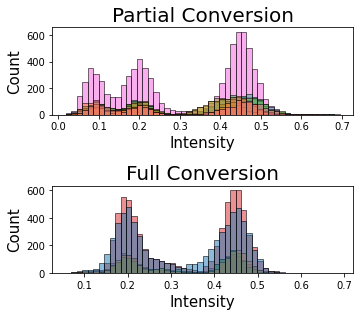

In [28]:

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(5,4), facecolor='white')
fig.tight_layout(h_pad=5)
sns.histplot(data=atomsdf[atomsdf['conversion']=='partial'], x='scaled intensity', hue='image name', bins=50, ax=ax[0], legend=False)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].set_xlabel('Intensity', fontsize=15)
ax[0].set_title('Partial Conversion', fontsize=20)

sns.histplot(data=atomsdf[atomsdf['conversion']=='full'], x='scaled intensity', hue='image name', bins=50, ax=ax[1], legend=False)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].set_xlabel('Intensity', fontsize=15)
ax[1].set_title('Full Conversion', fontsize=20)

fig.savefig('aligned intensities.png', bbox_inches='tight', dpi=300)
fig.savefig('aligned intensities.svg', bbox_inches='tight')
plt.show()

This looks much better. Now we can put these back together.

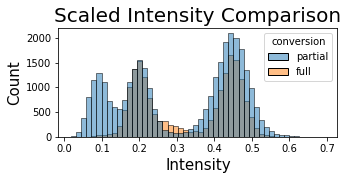

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2), facecolor='white')
sns.histplot(data=atomsdf, x='scaled intensity', hue='conversion', bins=50, ax=ax)
ax.set_ylabel('Count', fontsize=15)
ax.set_xlabel('Intensity', fontsize=15)
ax.set_title('Scaled Intensity Comparison', fontsize=20)

fig.savefig('scaled intensity comparison.png', bbox_inches='tight', dpi=300)
fig.savefig('scaled intensity comparison.svg', bbox_inches='tight')
plt.show()

We are particularly interested in the small shoulder showing up on the fully converted sample. Let's fit gaussian curves to both of these histograms.

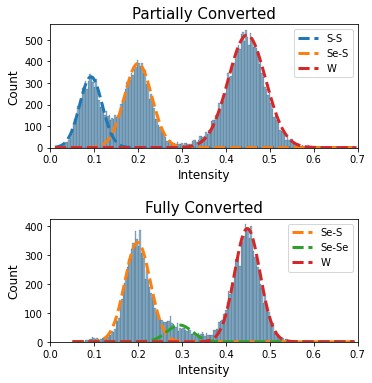

In [30]:
# select data
fulldf = atomsdf[atomsdf['conversion']=='full']
partialdf = atomsdf[atomsdf['conversion']=='partial']
intensities_full = np.array(fulldf['scaled intensity'])
intensities_partial = np.array(partialdf['scaled intensity'])
num_bins=200

# create histogram data from the intensities
hist_vector_full, bin_width_full, offset_full, bins_full = create_histogram(intensities_full, num_bins)
hist_vector_partial, bin_width_partial, offset_partial, bins_partial = create_histogram(intensities_partial, num_bins)

# we don't want to fit the full histogram, so we cut it off with the threshold
thr = 0.15
ind = np.where(bins_full[:-1]>thr)

# fit
# The triple gaussian with free sigma parameters does not fit well in the fully converted case because it is trying to force the small peak
# to be a broad background. This is not physically meaningful. Instead we force all three peaks to be the same width which is approximately
# what we expect to see based on scattering physics. Then the fit comes out much better behaved.
guess = [328, 0.2,
        50, 0.28,
        355, 0.45, 0.02]
parameters_full, covariance_full = curve_fit(triple_gauss_fixed_sigma, bins_full[ind], hist_vector_full[ind], p0=guess)
parameters_partial, covariance_partial = curve_fit(triple_gauss, bins_partial[:-1], hist_vector_partial, p0=partial_parms[0])


# generate data based on the optimized fit
parms1 = np.array([parameters_full[0], parameters_full[1], parameters_full[6]])
parms2 = np.array([parameters_full[2], parameters_full[3], parameters_full[6]])
parms3 = np.array([parameters_full[4], parameters_full[5], parameters_full[6]])

fit_y1_full = gauss(bins_full[:-1], *parms1)
fit_y2_full = gauss(bins_full[:-1], *parms2)
fit_y3_full = gauss(bins_full[:-1], *parms3)
fit_y4_full = triple_gauss_fixed_sigma(bins_full[:-1], *parameters_full)

fit_y1_partial = gauss(bins_partial[:-1], *parameters_partial[0:3])
fit_y2_partial = gauss(bins_partial[:-1], *parameters_partial[3:6])
fit_y3_partial = gauss(bins_partial[:-1], *parameters_partial[6:9])

#guessy = quad_gauss(bins_full[:-1], *guess)
colors=sns.color_palette()
# plot gauss fits
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5), facecolor='white')
fig.tight_layout(h_pad=5)
sns.histplot(intensities_partial, bins=num_bins, ax=ax[0], kde=False, alpha=0.5)
ax[0].set_xlabel('Intensity', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Partially Converted', fontsize=15)
ax[0].plot(bins_partial[:-1], fit_y1_partial, label='S-S', linewidth=linewidth, linestyle='--', color=colors[0])
ax[0].plot(bins_partial[:-1], fit_y3_partial, label='Se-S', linewidth=linewidth, linestyle='--', color=colors[1])
ax[0].plot(bins_partial[:-1], fit_y2_partial, label='W', linewidth=linewidth, linestyle='--', color=colors[3])
ax[0].legend()
ax[0].set_xlim(0,0.7)

sns.histplot(intensities_full, bins=num_bins, ax=ax[1], kde=False, alpha=0.5)
ax[1].set_xlabel('Intensity', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Fully Converted', fontsize=15)
ax[1].plot(bins_full[:-1], fit_y1_full, label='Se-S', linewidth=linewidth, linestyle='--', color=colors[1])
ax[1].plot(bins_full[:-1], fit_y2_full, label='Se-Se', linewidth=linewidth, linestyle='--', color=colors[2])
ax[1].plot(bins_full[:-1], fit_y3_full, label='W', linewidth=linewidth, linestyle='--', color=colors[3])
#ax[1].plot(bins_full[:-1], fit_y4_full, label='Gaussian Sum', linewidth=linewidth, linestyle='--')
#ax[1].plot(bins_full[:-1], guessy, label='guess', linewidth=linewidth, linestyle='--')
ax[1].legend()
ax[1].set_xlim(0,0.7)

fig.savefig('aligned comparison.png', bbox_inches='tight', dpi=300)
fig.savefig('aligned comparison.svg', bbox_inches='tight')
plt.show()

Next, we want to look at a few example intensity profiles. The DCNN is trained to find atoms, not every lattice site. For example double vacancies and sulfur-vacancy sites are very low in intensity. The DCNN is trying to find atom positions and these sites look like no atom is there so the DCNN ignores them (as it should). But we can pick out examples of different intensities observed in the image and compare them to the histogram of intensities we have already found.

Through manual inspection in another software program we find locations from which we want to extract intensity profiles for comparison.

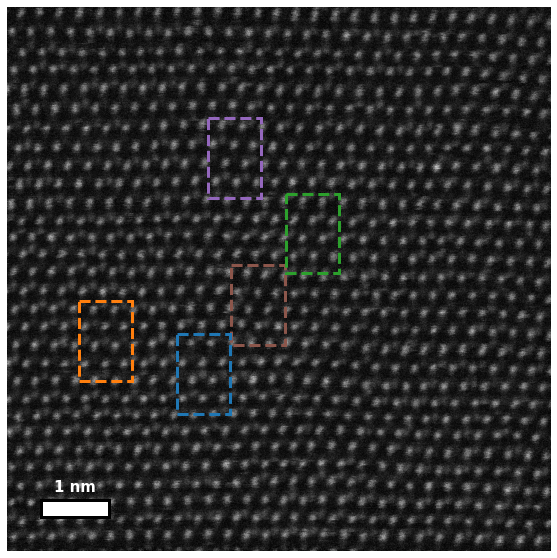

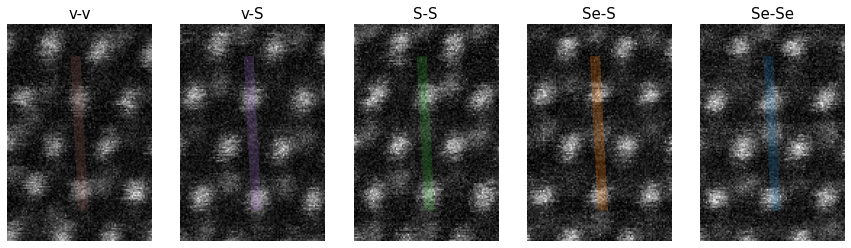

In [37]:
# Use this flag to plot atom positions and labels. Helpful for debugging and knowing which atoms in the dataframe are the ones of interest.
label_atoms=False

# We will use this line profile tool
from skimage.measure import profile_line

# We want this specific image. But we now have two versions of it. The dataframe uses the first name, but we want the rescaled intensities
# so we define both names and use as needed.
partial_name = 'Partially converted images/SuperScan (HAADF) 9_corrected.tif'
partial_rescaled_name = 'Partially converted images/SuperScan (HAADF) 9_corrected_rescaled.tif'

# Open the image
with Image.open(partial_rescaled_name) as img:
    partial_im = np.array(img)

image = partial_im

# create our figure handles
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10), facecolor='white')
fig2, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,10), facecolor='white')


# plot the image
ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
#ax[0].set_title('HAADF', fontsize=30)

# add scale bar
x = np.shape(image)[0]/16
rough_width = np.shape(image)[0]/4
nms = int(rough_width*scale)
width = int(nms/scale)
height = np.shape(image)[1]/32
y = np.shape(image)[1]-x-height
rect = Rectangle((x,y), width=width, height=height,
                    edgecolor = 'black',
                    facecolor = 'white',
                    fill=True,
                    lw=3)
ax1.add_patch(rect)
ax1.annotate(str(nms)+' nm', xy=(x+width/2,y-height/2), color='w', size=15, ha='center', weight='bold')

# approximate centers of examples of interest found by visual inspection in other software
vv_center = (560, 472)
vs_center = (283, 428)
ss_center = (426, 575)
ses_center = (628, 185)
sese_center = (691, 369)

# define the dimensions of the box around the lattice site we are interested in
roi_width = 100
roi_height = 150

# This will save a bit of repetative code.
# We find the top left corner of the bounding box around the example of interest
# and return this position as well as a Rectangle object to put on the plot
def get_roi(center, color, half_width=50, half_height=75):
    posx = int(center[1]-half_width)
    posy = int(center[0]-half_height)
    roi = Rectangle((posx,posy), width=half_width*2, height=half_height*2,
                        edgecolor = color,
                        facecolor = None,
                        fill=False,
                        lw=3, linestyle = '--')
    return posx, posy, roi

# to make uniform color scheme
cols = sns.color_palette()
vv_col = cols[5]
vs_col = cols[4]
ss_col = cols[2]
ses_col = cols[1]
sese_col = cols[0]

# Get roi positions
vv_posx, vv_posy, vv_roi = get_roi(vv_center, vv_col, roi_width/2, roi_height/2)
vs_posx, vs_posy, vs_roi = get_roi(vs_center, vs_col, roi_width/2, roi_height/2)
ss_posx, ss_posy, ss_roi = get_roi(ss_center, ss_col, roi_width/2, roi_height/2)
ses_posx, ses_posy, ses_roi = get_roi(ses_center, ses_col, roi_width/2, roi_height/2)
sese_posx, sese_posy, sese_roi = get_roi(sese_center, sese_col, roi_width/2, roi_height/2)

# plot rois
ax1.add_patch(vv_roi)
ax1.add_patch(vs_roi)
ax1.add_patch(ss_roi)
ax1.add_patch(ses_roi)
ax1.add_patch(sese_roi)

# select data for this image
df2 = partialdf[partialdf['image name']==partial_name]

# This will reduce repetative code
# We are just selecting the atoms that are within the roi and returning their positions and index.
def get_roi_atoms(posx, posy, width=100, height=150):
    conditions = (df2['x']>posx) & (df2['x']<posx+width) & (df2['y']>posy) & (df2['y']<posy+height)
    atom_pos_0 = df2[conditions]['x']
    atom_pos_1 = df2[conditions]['y']
    index = df2[conditions]['atom number']
    return atom_pos_0, atom_pos_1, index

# Get atom positions
vv_atom_posx, vv_atom_posy, vv_atom_index = get_roi_atoms(vv_posx, vv_posy, roi_width, roi_height)
vs_atom_posx, vs_atom_posy, vs_atom_index = get_roi_atoms(vs_posx, vs_posy, roi_width, roi_height)
ss_atom_posx, ss_atom_posy, ss_atom_index = get_roi_atoms(ss_posx, ss_posy, roi_width, roi_height)
ses_atom_posx, ses_atom_posy, ses_atom_index = get_roi_atoms(ses_posx, ses_posy, roi_width, roi_height)
sese_atom_posx, sese_atom_posy, sese_atom_index = get_roi_atoms(sese_posx, sese_posy, roi_width, roi_height)

# plot the atoms as an overlay on the image
#ax[0].scatter(vv_atom_posx, vv_atom_posy, s=10, color='red')
#ax[0].scatter(vs_atom_posx, vs_atom_posy, s=10, color='red')
#ax[0].scatter(ss_atom_posx, ss_atom_posy, s=10, color='red')
#ax[0].scatter(ses_atom_posx, ses_atom_posy, s=10, color='red')
#ax[0].scatter(sese_atom_posx, sese_atom_posy, s=10, color='red')


# Get the clips
vv_clip = image[vv_posy:vv_posy+roi_height, vv_posx:vv_posx+roi_width]
vs_clip = image[vs_posy:vs_posy+roi_height, vs_posx:vs_posx+roi_width]
ss_clip = image[ss_posy:ss_posy+roi_height, ss_posx:ss_posx+roi_width]
ses_clip = image[ses_posy:ses_posy+roi_height, ses_posx:ses_posx+roi_width]
sese_clip = image[sese_posy:sese_posy+roi_height, sese_posx:sese_posx+roi_width]

# Show the clips
ax[0].imshow(vv_clip, cmap='gray')
ax[1].imshow(vs_clip, cmap='gray')
ax[2].imshow(ss_clip, cmap='gray')
ax[3].imshow(ses_clip, cmap='gray')
ax[4].imshow(sese_clip, cmap='gray')

# This will reduce repeat code
# Here we plot atom positions and annotations on the clips
def plot_atom_positions(posx, posy, roix, roiy, index, ax):
    ax.scatter(posx-roix, posy-roiy, s=10, color='red')
    for i, label in enumerate(index):
        ax.annotate(label, (posx.iloc[i]-roix+2, posy.iloc[i]-roiy), fontsize=15, color='red')

# use the boolean flag at the top of the cell to label the atoms
if label_atoms:
    plot_atom_positions(vv_atom_posx, vv_atom_posy, vv_posx, vv_posy, vv_atom_index, ax[0])
    plot_atom_positions(vs_atom_posx, vs_atom_posy, vs_posx, vs_posy, vs_atom_index, ax[1])
    plot_atom_positions(ss_atom_posx, ss_atom_posy, ss_posx, ss_posy, ss_atom_index, ax[2])
    plot_atom_positions(ses_atom_posx, ses_atom_posy, ses_posx, ses_posy, ses_atom_index, ax[3])
    plot_atom_positions(sese_atom_posx, sese_atom_posy, sese_posx, sese_posy, sese_atom_index, ax[4])

# Define a function used to generate a second point for the line profiles.
# Using this function ensures that the line profiles are all the same length and direction.
# This is unused in the updated code.
def get_second_point(initial_point, length, angle):
    x1 = initial_point[1]
    y1 = initial_point[0]
    angle_rad = angle * np.pi/180 # convert to radians
    x2 = int(np.round(x1 + length * np.sin(angle_rad)))
    y2 = int(np.round(y1 + length * np.cos(angle_rad)))
    return (y2, x2)

# We use this function to get the line profile.
# posx - x position of the bounding box
# posy - y position of the bounding box
# center - center of the bounding box (i.e. position of the lattice site of interest)
# length - length of the line profile
# angle - angle of the line profile in degrees
# clip - subimage of the parent image that is within the bounding box
# linewidth - width of the line profile
# RETURNS
# (y1, x1) - the (row, column) position in the clip coordinates of the start of the line profile
# (y2, x2) - the (row, column) position in the clip coordinates of the end of the line profile
# profile - 1D vector of the intensity profile of length 'length'
# x - 1D vector of the distance [nm] traversed by the line profile to be used for plotting (e.g. sns.plot(x=x, y=profile))
def get_line_profile(posx, posy, center, length, angle, clip, linewidth):
    x0 = center[1] - posx
    y0 = center[0] - posy
    angle_rad = angle * np.pi/180 # convert to radians
    x1 = int(np.round(x0 - (length * np.sin(angle_rad))/2))
    y1 = int(np.round(y0 - (length * np.cos(angle_rad))/2))
    x2 = int(np.round(x1 + length * np.sin(angle_rad)))
    y2 = int(np.round(y1 + length * np.cos(angle_rad)))
    profile = profile_line(clip, (y1, x1), (y2, x2), linewidth=linewidth)
    x = np.linspace(0, len(profile)-1, len(profile))*scale 
    return (y1, x1), (y2, x2), profile, x    

# get the line profiles
length=100
angle=3
linewidth=10
vv_start, vv_stop, vv_profile, vv_x = get_line_profile(vv_posx, vv_posy, vv_center, length, angle, vv_clip, linewidth)
vs_start, vs_stop, vs_profile, vs_x = get_line_profile(vs_posx, vs_posy, vs_center, length, angle, vs_clip, linewidth)
ss_start, ss_stop, ss_profile, ss_x = get_line_profile(ss_posx, ss_posy, ss_center, length, angle, ss_clip, linewidth)
ses_start, ses_stop, ses_profile, ses_x = get_line_profile(ses_posx, ses_posy, ses_center, length, angle, ses_clip, linewidth)
sese_start, sese_stop, sese_profile, sese_x = get_line_profile(sese_posx, sese_posy, sese_center, length, angle, sese_clip, linewidth)

# Plot the location where the profile was acquired
ax[0].plot([vv_start[1], vv_stop[1]], [vv_start[0], vv_stop[0]], color=vv_col, linewidth=linewidth, alpha=.25)
ax[1].plot([vs_start[1], vs_stop[1]], [vs_start[0], vs_stop[0]], color=vs_col, linewidth=linewidth, alpha=.25)
ax[2].plot([ss_start[1], ss_stop[1]], [ss_start[0], ss_stop[0]], color=ss_col, linewidth=linewidth, alpha=.25)
ax[3].plot([ses_start[1], ses_stop[1]], [ses_start[0], ses_stop[0]], color=ses_col, linewidth=linewidth, alpha=.25)
ax[4].plot([sese_start[1], sese_stop[1]], [sese_start[0], sese_stop[0]], color=sese_col, linewidth=linewidth, alpha=.25)
ax[0].set_title('v-v', fontsize=15)
ax[1].set_title('v-S', fontsize=15)
ax[2].set_title('S-S', fontsize=15)
ax[3].set_title('Se-S', fontsize=15)
ax[4].set_title('Se-Se', fontsize=15)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
ax[4].set_axis_off()
#ax[1].set_title('Atom Positions', fontsize=30)
fig.savefig('Partial profile locations parent image.svg', bbox_inches='tight')
fig.savefig('Partial profile locations parent image.png', bbox_inches='tight', dpi=300)
fig2.savefig('Partial profile locations.svg', bbox_inches='tight')
fig2.savefig('Partial profile locations.png', bbox_inches='tight', dpi=300)
plt.show()

The previous cell was getting unmanageably long so we will plot the extracted profiles in the next cell.

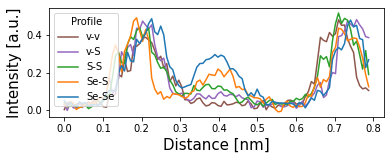

In [38]:
# Stack all the extracted data together in an organized dataframe 
# Stack intensity profiles
intens_profiles = np.hstack([vv_profile, vs_profile, ss_profile, ses_profile, sese_profile])

# stack labels
vv_index = ['v-v']*len(vv_profile)
vs_index = ['v-S']*len(vs_profile)
ss_index = ['S-S']*len(ss_profile)
ses_index = ['Se-S']*len(ses_profile)
sese_index = ['Se-Se']*len(sese_profile)
prof_index = np.hstack([vv_index, vs_index, ss_index, ses_index, sese_index])

# stack the distance vectors
dist = np.hstack([vv_x, vs_x, ss_x, ses_x, sese_x])

# create dataframe
profdf = pd.DataFrame({'Intensity':intens_profiles, 'Distance':dist, 'Profile':prof_index})

# finally we can plot these together and compare the extracted intensities
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2), facecolor='white')
cols = sns.color_palette()
sns.lineplot(data=profdf, x='Distance', y='Intensity', hue='Profile', ax=ax, palette=[vv_col, vs_col, ss_col, ses_col, sese_col])
ax.set_xlabel('Distance [nm]', fontsize=15)
ax.set_ylabel('Intensity [a.u.]', fontsize=15)
fig.savefig('partially converted intensity profile comparison.svg', bbox_inches='tight')
fig.savefig('partially converted intensity profile comparison.png', bbox_inches='tight', dpi=300)
plt.show()

Now let's do the same thing for an image of the fully converted sample. 

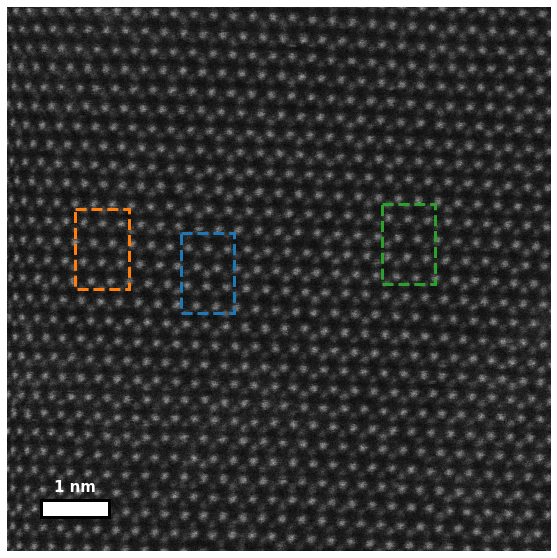

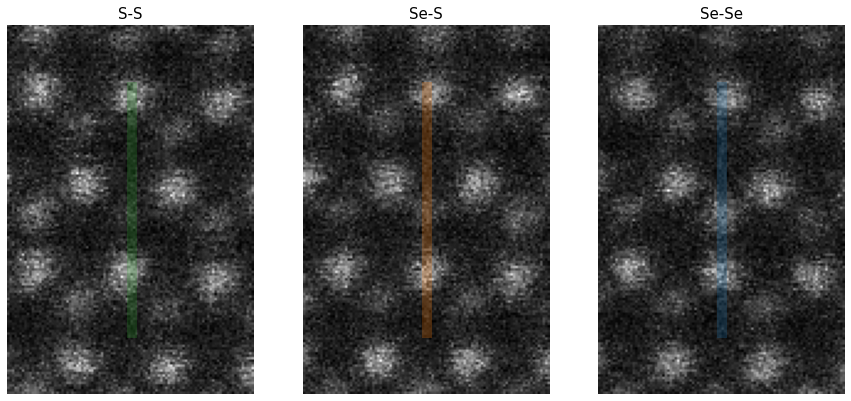

In [39]:
# Use this flag to plot atom positions and labels. Helpful for debugging and knowing which atoms in the dataframe are the ones of interest.
label_atoms=False

# We will use this line profile tool
from skimage.measure import profile_line

# We want this specific image. But we now have two versions of it. The dataframe uses the first name, but we want the rescaled intensities
# so we define both names and use as needed.
full_name = 'Fully converted images/SuperScan (HAADF) 14_corrected.tif'
full_rescaled_name = 'Fully converted images/SuperScan (HAADF) 14_corrected_rescaled.tif'

# Open the image
with Image.open(full_rescaled_name) as img:
    full_im = np.array(img)

# rescale as before
#image = (im - np.min(im))/np.max(im)
image = full_im

# create our figure handles
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10), facecolor='white')
fig2, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10), facecolor='white')


# plot the image
ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
#ax[0].set_title('HAADF', fontsize=30)

# add scale bar
x = np.shape(image)[0]/16
rough_width = np.shape(image)[0]/4
nms = int(rough_width*scale)
width = int(nms/scale)
height = np.shape(image)[1]/32
y = np.shape(image)[1]-x-height
rect = Rectangle((x,y), width=width, height=height,
                    edgecolor = 'black',
                    facecolor = 'white',
                    fill=True,
                    lw=3)
ax1.add_patch(rect)
ax1.annotate(str(nms)+' nm', xy=(x+width/2,y-height/2), color='w', size=15, ha='center', weight='bold')

# approximate centers of examples of interest found by visual inspection in other software
ss_center = (445, 755)
ses_center = (455, 178)
sese_center = (500, 376)

# define the dimensions of the box around the lattice site we are interested in
roi_width = 100
roi_height = 150

# This will save a bit of repetative code.
# We find the top left corner of the bounding box around the example of interest
# and return this position as well as a Rectangle object to put on the plot
def get_roi(center, color, half_width=50, half_height=75):
    posx = int(center[1]-half_width)
    posy = int(center[0]-half_height)
    roi = Rectangle((posx,posy), width=half_width*2, height=half_height*2,
                        edgecolor = color,
                        facecolor = None,
                        fill=False,
                        lw=3, linestyle = '--')
    return posx, posy, roi

# to make uniform color scheme
cols = sns.color_palette()
ss_col = cols[2]
ses_col = cols[1]
sese_col = cols[0]

# Get roi positions
ss_posx, ss_posy, ss_roi = get_roi(ss_center, ss_col, roi_width/2, roi_height/2)
ses_posx, ses_posy, ses_roi = get_roi(ses_center, ses_col, roi_width/2, roi_height/2)
sese_posx, sese_posy, sese_roi = get_roi(sese_center, sese_col, roi_width/2, roi_height/2)

# plot rois
ax1.add_patch(ss_roi)
ax1.add_patch(ses_roi)
ax1.add_patch(sese_roi)

# select data for this image
df2 = fulldf[fulldf['image name']==full_name]

# This will reduce repetative code
# We are just selecting the atoms that are within the roi and returning their positions and index.
def get_roi_atoms(posx, posy, width=100, height=150):
    conditions = (df2['x']>posx) & (df2['x']<posx+width) & (df2['y']>posy) & (df2['y']<posy+height)
    atom_pos_0 = df2[conditions]['x']
    atom_pos_1 = df2[conditions]['y']
    index = df2[conditions]['atom number']
    return atom_pos_0, atom_pos_1, index

# Get atom positions
ss_atom_posx, ss_atom_posy, ss_atom_index = get_roi_atoms(ss_posx, ss_posy, roi_width, roi_height)
ses_atom_posx, ses_atom_posy, ses_atom_index = get_roi_atoms(ses_posx, ses_posy, roi_width, roi_height)
sese_atom_posx, sese_atom_posy, sese_atom_index = get_roi_atoms(sese_posx, sese_posy, roi_width, roi_height)

# plot the atoms as an overlay on the image
#ax[0].scatter(vv_atom_posx, vv_atom_posy, s=10, color='red')
#ax[0].scatter(vs_atom_posx, vs_atom_posy, s=10, color='red')
#ax[0].scatter(ss_atom_posx, ss_atom_posy, s=10, color='red')
#ax[0].scatter(ses_atom_posx, ses_atom_posy, s=10, color='red')
#ax[0].scatter(sese_atom_posx, sese_atom_posy, s=10, color='red')


# Get the clips
ss_clip = image[ss_posy:ss_posy+roi_height, ss_posx:ss_posx+roi_width]
ses_clip = image[ses_posy:ses_posy+roi_height, ses_posx:ses_posx+roi_width]
sese_clip = image[sese_posy:sese_posy+roi_height, sese_posx:sese_posx+roi_width]

# Show the clips
ax[0].imshow(ss_clip, cmap='gray')
ax[1].imshow(ses_clip, cmap='gray')
ax[2].imshow(sese_clip, cmap='gray')

# This will reduce repeat code
# Here we plot atom positions and annotations on the clips
def plot_atom_positions(posx, posy, roix, roiy, index, ax):
    ax.scatter(posx-roix, posy-roiy, s=10, color='red')
    for i, label in enumerate(index):
        ax.annotate(label, (posx.iloc[i]-roix+2, posy.iloc[i]-roiy), fontsize=15, color='red')

# use the boolean flag at the top of the cell to label the atoms
if label_atoms:
    plot_atom_positions(ss_atom_posx, ss_atom_posy, ss_posx, ss_posy, ss_atom_index, ax[0])
    plot_atom_positions(ses_atom_posx, ses_atom_posy, ses_posx, ses_posy, ses_atom_index, ax[1])
    plot_atom_positions(sese_atom_posx, sese_atom_posy, sese_posx, sese_posy, sese_atom_index, ax[2])

# Define a function used to generate a second point for the line profiles.
# Using this function ensures that the line profiles are all the same length and direction.
# This is unused in the updated code.
def get_second_point(initial_point, length, angle):
    x1 = initial_point[1]
    y1 = initial_point[0]
    angle_rad = angle * np.pi/180 # convert to radians
    x2 = int(np.round(x1 + length * np.sin(angle_rad)))
    y2 = int(np.round(y1 + length * np.cos(angle_rad)))
    return (y2, x2)

# We use this function to get the line profile.
# posx - x position of the bounding box
# posy - y position of the bounding box
# center - center of the bounding box (i.e. position of the lattice site of interest)
# length - length of the line profile
# angle - angle of the line profile in degrees
# clip - subimage of the parent image that is within the bounding box
# linewidth - width of the line profile
# RETURNS
# (y1, x1) - the (row, column) position in the clip coordinates of the start of the line profile
# (y2, x2) - the (row, column) position in the clip coordinates of the end of the line profile
# profile - 1D vector of the intensity profile of length 'length'
# x - 1D vector of the distance [nm] traversed by the line profile to be used for plotting (e.g. sns.plot(x=x, y=profile))
def get_line_profile(posx, posy, center, length, angle, clip, linewidth):
    x0 = center[1] - posx
    y0 = center[0] - posy
    angle_rad = angle * np.pi/180 # convert to radians
    x1 = int(np.round(x0 - (length * np.sin(angle_rad))/2))
    y1 = int(np.round(y0 - (length * np.cos(angle_rad))/2))
    x2 = int(np.round(x1 + length * np.sin(angle_rad)))
    y2 = int(np.round(y1 + length * np.cos(angle_rad)))
    profile = profile_line(clip, (y1, x1), (y2, x2), linewidth=linewidth)
    x = np.linspace(0, len(profile)-1, len(profile))*scale 
    return (y1, x1), (y2, x2), profile, x    

# get the line profiles
length=100
angle=0
linewidth=10
ss_start, ss_stop, ss_profile, ss_x = get_line_profile(ss_posx, ss_posy, ss_center, length, angle, ss_clip, linewidth)
ses_start, ses_stop, ses_profile, ses_x = get_line_profile(ses_posx, ses_posy, ses_center, length, angle, ses_clip, linewidth)
sese_start, sese_stop, sese_profile, sese_x = get_line_profile(sese_posx, sese_posy, sese_center, length, angle, sese_clip, linewidth)

# Plot the location where the profile was acquired
ax[0].plot([ss_start[1], ss_stop[1]], [ss_start[0], ss_stop[0]], color=ss_col, linewidth=linewidth, alpha=.25)
ax[1].plot([ses_start[1], ses_stop[1]], [ses_start[0], ses_stop[0]], color=ses_col, linewidth=linewidth, alpha=.25)
ax[2].plot([sese_start[1], sese_stop[1]], [sese_start[0], sese_stop[0]], color=sese_col, linewidth=linewidth, alpha=.25)
ax[0].set_title('S-S', fontsize=15)
ax[1].set_title('Se-S', fontsize=15)
ax[2].set_title('Se-Se', fontsize=15)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
#ax[1].set_title('Atom Positions', fontsize=30)
fig.savefig('Full profile locations parent image.svg', bbox_inches='tight')
fig.savefig('Full profile locations parent image.png', bbox_inches='tight', dpi=300)
fig2.savefig('Full profile locations.svg', bbox_inches='tight')
fig2.savefig('Full profile locations.png', bbox_inches='tight', dpi=300)
plt.show()

We failed to find convincing examples of the vacancy states that showed a significantly different intensity from the S-S example. 

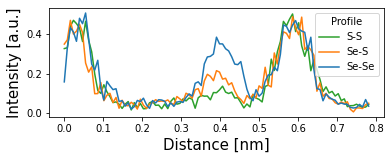

In [40]:
# Stack all the extracted data together in an organized dataframe
# Stack intensity profiles
intens_profiles = np.hstack([ss_profile, ses_profile, sese_profile])

# stack labels
ss_index = ['S-S']*len(ss_profile)
ses_index = ['Se-S']*len(ses_profile)
sese_index = ['Se-Se']*len(sese_profile)
prof_index = np.hstack([ss_index, ses_index, sese_index])

# stack the distance vectors
dist = np.hstack([ss_x, ses_x, sese_x])

# create dataframe
full_profdf = pd.DataFrame({'Intensity':intens_profiles, 'Distance':dist, 'Profile':prof_index})

# finally we can plot these together and compare the extracted intensities
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2), facecolor='white')
cols = sns.color_palette()
sns.lineplot(data=full_profdf, x='Distance', y='Intensity', hue='Profile', ax=ax, palette=[ss_col, ses_col, sese_col])
ax.set_xlabel('Distance [nm]', fontsize=15)
ax.set_ylabel('Intensity [a.u.]', fontsize=15)
fig.savefig('fully converted intensity profile comparison.svg', bbox_inches='tight')
fig.savefig('fully converted intensity profile comparison.png', bbox_inches='tight', dpi=300)
plt.show()


Next we want to plot these intensities as vertical lines on our histograms to visualize where they fall with respect to the intensities of the other found atoms.

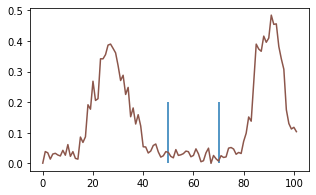

In [41]:
# Using the flag label_atoms=True in the previous cells gives us the atom index for the examples where the atom was found.
# With this information we can copy down the indices of the atoms we want to find the intensities for.
#                 S-S  Se-S Se-Se
full_atoms_ind = [680, 692, 763]
full_intensities = fulldf[fulldf['image name']==full_name].iloc[full_atoms_ind]['scaled intensity'].values
#                    v-S  S-S  Se-S Se-Se
partial_atoms_ind = [399, 615, 933, 1030]
partial_intensities = partialdf[partialdf['image name']==partial_name].iloc[partial_atoms_ind]['scaled intensity'].values

# the v-v atom position was not found (because there is no atom there) so there is no logged intensity for this lattice site.
# Instead we will have to use the intensity profile for this case.
# Let's plot the vv profile and determine a range over which to get an average value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3), facecolor='white')
sns.lineplot(x=vv_x/scale, y=vv_profile, ax=ax, color=vv_col) # we divide by scale here to get back the x dimension in pixels instead of nm
ax.vlines(50, 0, 0.2)
ax.vlines(70, 0, 0.2)
plt.show()

It looks like a range 50-70 represents this intensity level. Let's put this mean value into the intensity array.

In [42]:
mn = vv_profile[50:71].mean()
partial_intensities = np.insert(partial_intensities, 0, mn, axis=0)

Now let's replot our histograms with vertical lines marking the examined intensities.

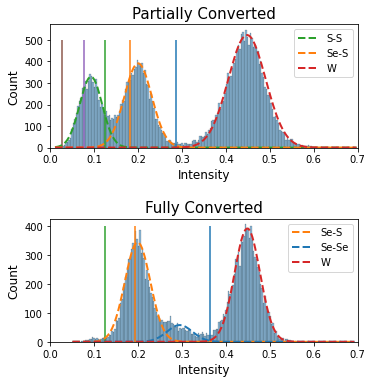

In [43]:
linewidth = 2
# plot gauss fits
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5), facecolor='white')
fig.tight_layout(h_pad=5)
sns.histplot(intensities_partial, bins=num_bins, ax=ax[0], kde=False, alpha=0.5)
ax[0].set_xlabel('Intensity', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Partially Converted', fontsize=15)
ax[0].plot(bins_partial[:-1], fit_y1_partial, label='S-S', linewidth=linewidth, linestyle='--', color=ss_col)
ax[0].plot(bins_partial[:-1], fit_y3_partial, label='Se-S', linewidth=linewidth, linestyle='--', color=ses_col)
ax[0].plot(bins_partial[:-1], fit_y2_partial, label='W', linewidth=linewidth, linestyle='--', color=colors[3])
ax[0].legend()
ax[0].set_xlim(0,0.7)

for intensity, col in zip(partial_intensities, [vv_col,vs_col,ss_col,ses_col,sese_col]):
    ax[0].vlines(intensity, 0, 500, color=col)

sns.histplot(intensities_full, bins=num_bins, ax=ax[1], kde=False, alpha=0.5)
ax[1].set_xlabel('Intensity', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Fully Converted', fontsize=15)
ax[1].plot(bins_full[:-1], fit_y1_full, label='Se-S', linewidth=linewidth, linestyle='--', color=ses_col)
ax[1].plot(bins_full[:-1], fit_y2_full, label='Se-Se', linewidth=linewidth, linestyle='--', color=sese_col)
ax[1].plot(bins_full[:-1], fit_y3_full, label='W', linewidth=linewidth, linestyle='--', color=colors[3])
#ax[1].plot(bins_full[:-1], fit_y4_full, label='Gaussian Sum', linewidth=linewidth, linestyle='--')
#ax[1].plot(bins_full[:-1], guessy, label='guess', linewidth=linewidth, linestyle='--')
ax[1].legend()
ax[1].set_xlim(0,0.7)

for intensity, col in zip(full_intensities, [ss_col,ses_col,sese_col]):
    ax[1].vlines(intensity, 0, 400, color=col)

fig.savefig('aligned comparison with vertical lines.png', bbox_inches='tight', dpi=300)
fig.savefig('aligned comparison with vertical lines.svg', bbox_inches='tight')
plt.show()

At this point we have shown that the identified intensity peaks are attributed correctly. The vacancy sites are not significantly different in intensity from the tail of the S-S peak so it is likely we cannot unambiguously discriminate between them. It is also worth noting that a v-Se site likely has approximately the same intensity as the S-S so we cannot discriminate between these either. However, given the magnitude of the S-S peak, it cannot be primarily composed of vacancy sites or the material would collapse. Thus, it must be majority S-S sites with a few vacancy configurations.

Next we would like to visualize these sites as an overlay on the images. To do this, we will use k-means clustering to group the atoms by intensity using small tiles of the parent image centered around the atomic positions.

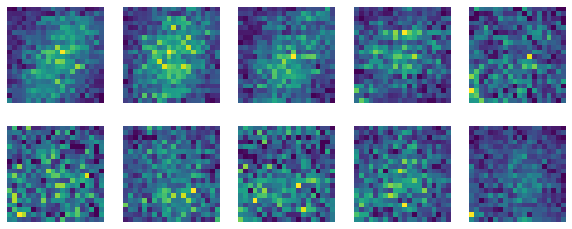

In [44]:
# We are going to select an image tile around every atomic position in the image.

# Helper function that slices the parent image and returns an image tile centered around the specified atom.
def get_tile(x, y, width, image):
    xmin = int(np.round(x-width/2))
    xmax = int(np.round(x+width/2))
    ymin = int(np.round(y-width/2))
    ymax = int(np.round(y+width/2))
    tile = image[ymin:ymax,xmin:xmax]
    return tile

# width of the tile
width = 20
w = width + 1 # use this addition to exclude more or less of the edge of the image

# Select the data we want
fdf = fulldf[fulldf['image name']==full_name]

# iterate through the atoms and slice out the tiles
full_tile_array = np.zeros((fdf.shape[0],width*width))
for i in range(len(fdf)):
        x = fdf.iloc[i]['x']
        y = fdf.iloc[i]['y']

        # check if the point is too close to the edge of the image
        if (x > w) & (x < np.shape(full_im)[0]-w) & (y > w) & (y < np.shape(full_im)[1]-w):
            tile = get_tile(x, y, width, full_im)
            full_tile_array[i]=np.ravel(tile)

# and the same with the partially converted image
# Select the data we want
pdf = partialdf[partialdf['image name']==partial_name]

# iterate through the atoms and slice out the tiles
partial_tile_array = np.zeros((pdf.shape[0],width*width))
for i in range(len(pdf)):
        x = pdf.iloc[i]['x']
        y = pdf.iloc[i]['y']

        # check if the point is too close to the edge of the image
        if (x > w) & (x < np.shape(partial_im)[0]-w) & (y > w) & (y < np.shape(partial_im)[1]-w):
            tile = get_tile(x, y, width, partial_im)
            partial_tile_array[i]=np.ravel(tile)

# let's visualize a few tiles to keep track of what we are doing
atom_indices = np.where(partial_tile_array.sum(axis=1)>0) # excludes tiles too close to the edge (which are just zero)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), facecolor='white')
for i, ax in zip(range(10), np.ravel(ax)):
    ax.imshow(partial_tile_array[atom_indices][i].reshape(width, width))
    ax.set_axis_off()

plt.show()

The set of images above shows examples of the first few tiles. 

Now we will perform k-means clustering on the tiles.

/tmp/ipykernel_3969431/2644517973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_atomsdf['k-means labels'] = km.labels_
/tmp/ipykernel_3969431/2644517973.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_atomsdf['Type'] = temp


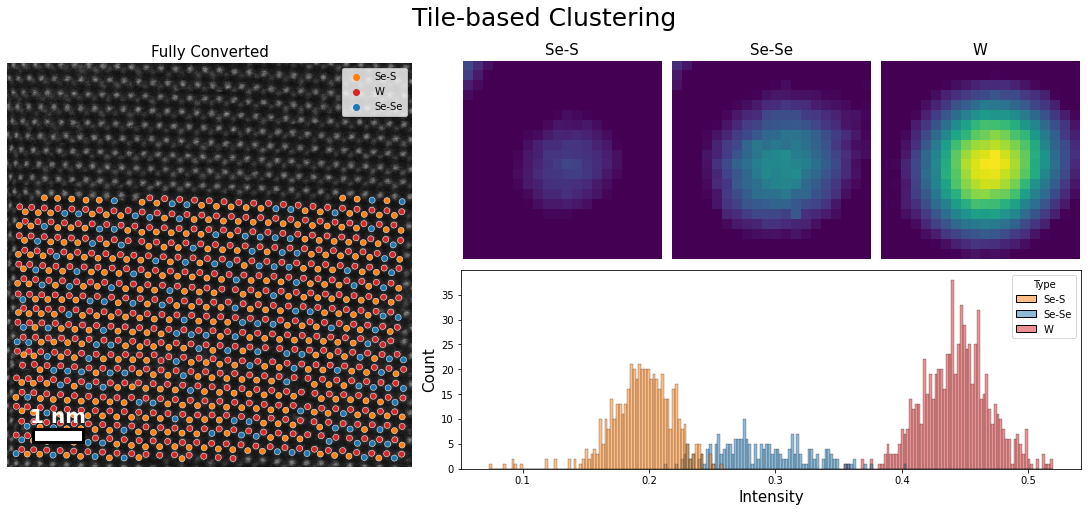

In [45]:

offset = 1024/3 # use this to ignore atoms at the top of the image so that we have more of the HAADF showing

# select the atoms not near the edge
full_atom_indices = np.where(full_tile_array.sum(axis=1)>0)
full_atomsdf = fdf.iloc[full_atom_indices]
full_tile_array_sub = full_tile_array[full_atom_indices]

# perform clustering based on the tiles
clusters = 3
model = KMeans(n_clusters=clusters, random_state=42) 
km = model.fit(np.array(full_tile_array_sub))
full_atomsdf['k-means labels'] = km.labels_
full_atomsdf.index = np.arange(len(full_atomsdf))

# create labels based on prior cell execution (i.e. we know what the k-means labels correspond to)
temp = np.array(['null']*len(full_atomsdf), np.dtype(('U', 10)))
zero_ind = full_atomsdf[full_atomsdf['k-means labels']==0].index
one_ind = full_atomsdf[full_atomsdf['k-means labels']==1].index
two_ind = full_atomsdf[full_atomsdf['k-means labels']==2].index
temp[zero_ind] = 'Se-S'
temp[one_ind] = 'Se-Se'
temp[two_ind] = 'W'
full_atomsdf['Type'] = temp

# plotting

# create figure object
fig = plt.figure(constrained_layout=True, figsize=(15,7), facecolor='white')
gs = GridSpec(2, 5, figure=fig)

# add the tiles to an array based on the label
templates = np.zeros((clusters,width,width))
for label, tile in zip(km.labels_, full_tile_array_sub):
    templates[label]+=np.reshape(tile, (width,width))

# create all the axes
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[-1, -3:])

# show the image
ax1.imshow(full_im, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Fully Converted', fontsize=15)

# need scale bar
x = np.shape(full_im)[0]/16
rough_width = np.shape(full_im)[0]/4
nms = int(rough_width*scale)
scalebarwidth = int(nms/scale)
scalebarheight = np.shape(image)[1]/32
y = np.shape(image)[1]-x-height
rect = Rectangle((x,y), width=scalebarwidth, height=scalebarheight,
                    edgecolor = 'black',
                    facecolor = 'white',
                    fill=True,
                    lw=3)
ax1.add_patch(rect)
ax1.annotate(str(nms)+' nm', xy=(x+scalebarwidth/2,y-scalebarheight/2), color='w', size=20, ha='center', weight='bold')

# plot the atom positions as dots
full_offset = full_atomsdf[full_atomsdf['y']>offset]
full_offset_alpha = full_atomsdf[full_atomsdf['y']<offset]
sns.scatterplot(data=full_offset, x='x', y='y', ax=ax1, palette=[ses_col, cols[3], sese_col], hue='Type', alpha=1)
ax1.legend(loc='upper right')
#sns.scatterplot(data=full_offset_alpha, x='x', y='y', ax=ax1, palette='bright', hue='k-means labels', alpha=0.1)


# The templates were summed. For comparison we want the average.
counts = full_atomsdf.groupby('k-means labels')['k-means labels'].value_counts().values
for i, clip in enumerate(templates):
    templates[i] = clip/counts[i]

# Set the intensity values so we can compare across the tiles
vmin = 0.15
vmax = 0.5
# show the first tile
ax2.imshow(templates[0], vmin=vmin, vmax=vmax)
ax2.set_axis_off()
ax2.set_title('Se-S', fontsize=15)

# show the second tile
ax3.imshow(templates[1], vmin=vmin, vmax=vmax)
ax3.set_axis_off()
ax3.set_title('Se-Se', fontsize=15)

# show the third tile
ax4.imshow(templates[2], vmin=vmin, vmax=vmax)
ax4.set_axis_off()
ax4.set_title('W', fontsize=15)

# plot the histogram
sns.histplot(data=full_atomsdf, x='scaled intensity', hue='Type', bins=num_bins, ax=ax5, palette=[ses_col, sese_col, cols[3]])
ax5.set_ylabel('Count', fontsize=15)
ax5.set_xlabel('Intensity', fontsize=15)

# global title
fig.suptitle("Tile-based Clustering", fontsize=25)

fig.savefig('tile-based clustering full conversion.png', bbox_inches='tight', dpi=300)
fig.savefig('tile-based clustering full conversion.svg', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3969431/886486539.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_atomsdf['k-means labels'] = km.labels_
/tmp/ipykernel_3969431/886486539.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_atomsdf['Type'] = temp


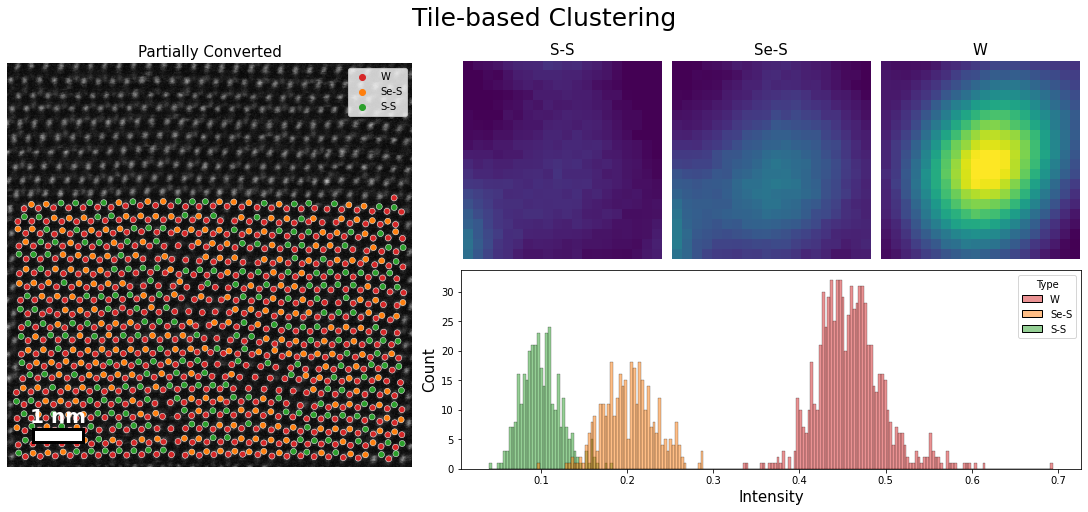

In [46]:
offset = 1024/3 # use this to ignore atoms at the top of the image so that we have more of the HAADF showing

# select the atoms not near the edge
partial_atom_indices = np.where(partial_tile_array.sum(axis=1)>0)
partial_atomsdf = pdf.iloc[partial_atom_indices]
partial_tile_array_sub = partial_tile_array[partial_atom_indices]

# perform clustering based on the tiles
clusters = 3
model = KMeans(n_clusters=clusters, random_state=42) 
km = model.fit(np.array(partial_tile_array_sub))
partial_atomsdf['k-means labels'] = km.labels_
partial_atomsdf.index = np.arange(len(partial_atomsdf))

# create labels based on prior cell execution (i.e. we know what the k-means labels correspond to)
temp = np.array(['null']*len(partial_atomsdf), np.dtype(('U', 10)))
zero_ind = partial_atomsdf[partial_atomsdf['k-means labels']==0].index
one_ind = partial_atomsdf[partial_atomsdf['k-means labels']==1].index
two_ind = partial_atomsdf[partial_atomsdf['k-means labels']==2].index
temp[zero_ind] = 'W'
temp[one_ind] = 'S-S'
temp[two_ind] = 'Se-S'
partial_atomsdf['Type'] = temp

# plotting

# create figure object
fig = plt.figure(constrained_layout=True, figsize=(15,7), facecolor='white')
gs = GridSpec(2, 5, figure=fig)

# add the tiles to an array based on the label
templates = np.zeros((clusters,width,width))
for label, tile in zip(km.labels_, partial_tile_array_sub):
    templates[label]+=np.reshape(tile, (width,width))

# create all the axes
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[-1, -3:])

# show the image
ax1.imshow(partial_im, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Partially Converted', fontsize=15)

# need scale bar
x = np.shape(partial_im)[0]/16
rough_width = np.shape(partial_im)[0]/4
nms = int(rough_width*scale)
scalebarwidth = int(nms/scale)
scalebarheight = np.shape(partial_im)[1]/32
y = np.shape(image)[1]-x-height
rect = Rectangle((x,y), width=scalebarwidth, height=scalebarheight,
                    edgecolor = 'black',
                    facecolor = 'white',
                    fill=True,
                    lw=3)
ax1.add_patch(rect)
ax1.annotate(str(nms)+' nm', xy=(x+scalebarwidth/2,y-scalebarheight/2), color='w', size=20, ha='center', weight='bold')

# plot the atom positions as dots
partial_offset = partial_atomsdf[partial_atomsdf['y']>offset]
partial_offset_alpha = partial_atomsdf[partial_atomsdf['y']<offset]
sns.scatterplot(data=partial_offset, x='x', y='y', ax=ax1, palette=[ cols[3],ses_col, ss_col], hue='Type', alpha=1)
ax1.legend(loc='upper right')
#sns.scatterplot(data=full_offset_alpha, x='x', y='y', ax=ax1, palette='bright', hue='k-means labels', alpha=0.1)


# The templates were summed. For comparison we want the average.
counts = partial_atomsdf.groupby('k-means labels')['k-means labels'].value_counts().values
for i, clip in enumerate(templates):
    templates[i] = clip/counts[i]

# Set the intensity values so we can compare across the tiles
vmin = 0.05
vmax = 0.5
# show the first tile
ax2.imshow(templates[1], vmin=vmin, vmax=vmax)
ax2.set_axis_off()
ax2.set_title('S-S', fontsize=15)

# show the second tile
ax3.imshow(templates[2], vmin=vmin, vmax=vmax)
ax3.set_axis_off()
ax3.set_title('Se-S', fontsize=15)

# show the third tile
ax4.imshow(templates[0], vmin=vmin, vmax=vmax)
ax4.set_axis_off()
ax4.set_title('W', fontsize=15)

# plot the histogram
sns.histplot(data=partial_atomsdf, x='scaled intensity', hue='Type', bins=num_bins, ax=ax5, palette=[cols[3], ses_col, ss_col])
ax5.set_ylabel('Count', fontsize=15)
ax5.set_xlabel('Intensity', fontsize=15)

# global title
fig.suptitle("Tile-based Clustering", fontsize=25)

fig.savefig('tile-based clustering partially converted.png', bbox_inches='tight', dpi=300)
fig.savefig('tile-based clustering partially converted.svg', bbox_inches='tight')
plt.show()